In [9]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
os.environ['CUDA_VISIBLE_DEVICES']='1'
    
import pandas as pd
from tqdm import tqdm

In [17]:
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.optim as optim
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
data = torch.load('/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_t1_AD', map_location='cpu')

## Load one model

In [4]:
sys.path.append('/network/lustre/iss02/aramis/users/benoit.sautydechalon/deformetrica_MICCAI')
from deformetrica.core.model_tools.neural_networks.networks_LVAE import CVAE_3D, VAE_GAN
from deformetrica.support.utilities.general_settings import Settings

import deformetrica as dfca
from deformetrica.core.models import LongitudinalAutoEncoder
from deformetrica.LAE_experiments.fit_longitudinal_auto_encoder import *
from deformetrica.support.utilities.general_settings import Settings

In [5]:
path_CAE = 'output_AD/CVAE_longitudinal'
path_model = 'model_MRI.xml'
path_data = '/network/lustre/iss02/aramis/users/benoit.sautydechalon/miccai_2022/ADNI_t1_AD'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
xml_parameters = dfca.io.XmlParameters()
xml_parameters._read_model_xml(path_model)
Settings().dimension = 16
Settings().number_of_sources = 5
Settings().device = device
deformetrica = dfca.Deformetrica(output_dir='output', verbosity=logger.level)

Logger has been set to: NOTSET


In [6]:
#torch_data = torch.load(path_data)
image_data = Dataset(data['data'].unsqueeze(1).float(), data['labels'], data['timepoints'])
number_of_subjects = len(np.unique(image_data.labels))

model, dataset, individual_RER = instantiate_longitudinal_auto_encoder_model(logger, path_data, path_CAE=path_CAE,
                                                                    number_of_subjects=number_of_subjects, xml_parameters=xml_parameters)

Loaded 3585 train images and 100 test images
>> Loaded CAE network from output_AD/CVAE_longitudinal
Model has a total of 11535009 parameters
>> Reading 5-source initial modulation matrix from file: output_AD/LongitudinalMetricModel_modulation_matrix.txt
Setting initial onset ages from output_AD/LongitudinalMetricModel_onset_ages.txt file
Setting initial log accelerations from output_AD/LongitudinalMetricModel_log_accelerations.txt file
Initialized the Euclidean metric for latent space
Setting the Euclidean exponential dimension to 16 from the settings
Setting the Euclidean exponential dimension to 16 from the settings
Setting the Euclidean exponential dimension to 16 from the settings
Setting initial sources from output_AD/LongitudinalMetricModel_sources.txt file
>> The time shift variance prior degrees of freedom parameter is set to 784
>> The log-acceleration variance prior degrees of freedom parameter is set to the number of subjects: 784
('v0', False)
('p0', False)
('reference_time

## Then compare for different values of lambda

In [18]:
# Load the VAEs and compute their output
torch.cuda.empty_cache()

VAEs = ['../CVAE_longitudinal_0', '../CVAE_longitudinal_500', '../CVAE_longitudinal_1500', '../CVAE_longitudinal_2000']
outputs = []
train_L2, test_L2 = [], []

for path in VAEs:
    vae = CVAE_3D()
    vae.load_state_dict(torch.load(path))
    vae.to(device)
    vae.eval() 
    with torch.no_grad():
        outputs.append(vae(data['data'][:37].unsqueeze(1).to(device))[0].cpu().detach().numpy())
        test = model.train_images[:50].to(device)
        reconstructed = vae(test)[2]
        train_L2.append((((test - reconstructed)**2).sum()/test.shape[0]).cpu())
        test = model.test_images[:50].to(device)
        reconstructed = vae(test)[2]
        test_L2.append((((test - reconstructed)**2).sum()/test.shape[0]).cpu())

In [19]:
# First with the trained longitudinal model

z = model.full_encoded[:37]
labels = model.full_labels[:37]

already_seen = []
alpha = []
for i in range(len(labels)):
    if labels[i] not in already_seen:
        alpha.append(1)
        already_seen.append(labels[i])
    else:
        alpha.append(alpha[-1] * .85)

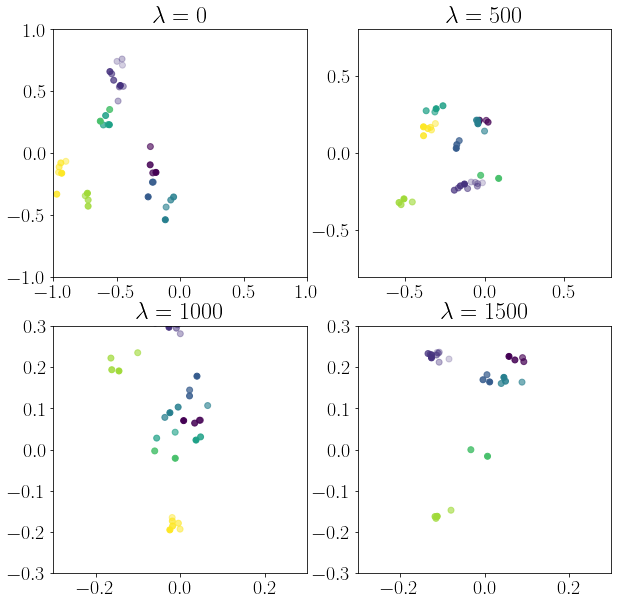

In [41]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'Computer Modern',
    'font.size':20,
})

fig, axes = plt.subplots(2, 2, figsize=(10,10))

titles = ['$\lambda = 0$', '$\lambda = 500$', '$\lambda = 1000$', '$\lambda = 1500$']
limits = [1, .8, .3, .3]

for i in range(len(outputs)):
    axes[i//2][i%2].scatter(outputs[i][:,0], outputs[i][:,1], c=labels, alpha=alpha)
    axes[i//2][i%2].title.set_text(titles[i])
    axes[i//2][i%2].set_xlim([-limits[i],limits[i]])
    axes[i//2][i%2].set_ylim([-limits[i],limits[i]])

plt.savefig('lambda_plots.png', dpi=300, bbox_inches='tight')
plt.show()

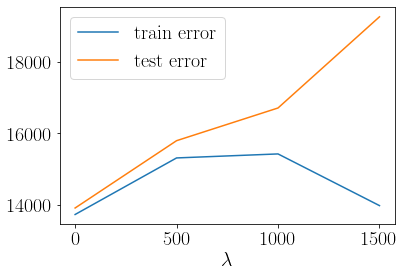

In [40]:
fig = plt.figure(figsize=(6,4))
                 
plt.plot([0,500,1000,1500], train_L2, label='train error')
plt.plot([0,500,1000,1500], test_L2, label='test error')
plt.xlabel('$\lambda$')
plt.legend()
plt.savefig('lambda_errors.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
torch.cuda.empty_cache()
model.CAE.training = False

model.CAE.to(device)
test = model.train_images[:50].to(device)

with torch.no_grad():
    reconstructed = model.CAE(test)[2]

print(f"Average reconstruction L2 is {((test - reconstructed)**2).sum()/test.shape[0]}")
print(f"Mean mutual information is {mutual_information(test.cpu(), reconstructed.cpu())}")

Average reconstruction L2 is 13554.392578125
Mean mutual information is 0.6828406806143871


In [24]:
model.CAE.to(device)
test = model.test_images[:50].to(device)

with torch.no_grad():
    reconstructed = model.CAE(test)[2]

print(f"Average reconstruction L2 is {((test - reconstructed)**2).sum()/test.shape[0]}")
print(f"Mean mutual information is {mutual_information(test.cpu(), reconstructed.cpu())}")

Average reconstruction L2 is 14730.3349609375
Mean mutual information is 0.5578475197217326
